<a href="https://colab.research.google.com/github/Remi-KC/data-course-sample/blob/main/W3_Collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [ ]:
import pandas as pd
import gzip, json
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

In [ ]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [ ]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [ ]:
# 利用 rank 中的類別資訊，刪除非美妝類產品，並刪除重複項
metadataB = metadata
for i in range(len(metadata)):
    if 'Beauty' not in metadata.loc[i]['rank']:
        metadataB = metadataB.drop(index = i)
metadataB.drop_duplicates('asin', inplace = True)

# 轉換 rank 資料成數字
splitR=metadataB['rank'].str.split(n=1, expand=True).rename(columns={0:'rank', 1:'cat'})
rank=splitR['rank'].replace(',','',regex=True)
rank=pd.to_numeric(rank)
metadataB = metadataB[['asin','title','description','brand','price']].join(rank)

# 轉換 price 資料成數字
splitP=metadataB['price'].str.split('$', expand=True).rename(columns={0:'none', 1:'price'})
price=splitP['price'].replace(',','',regex=True)
metadataB['price'] = pd.to_numeric(price)

# 處理文字欄位
import re
metadataB['description'] = metadataB['description'].apply(lambda x: ''.join(x))
metadataB['text'] = metadataB['brand'] + ' ' + metadataB['title'] + ' ' + metadataB['description']
metadataB['text'] = metadataB['text'].apply(lambda x: re.sub(r"[\W+]\.|\(|\)|,|-|'|\&amp;|(<[(/Br?)(/br?)]>)|<br>|\&|;", '', str(x))).str.lower() 
metadataB['brand'] = metadataB['brand'].apply(lambda x: re.sub(r"[\W+]\.|\(|\)|,|-|'|\&amp;|(<[(/Br?)(/br?)]>)|<br>|\&|;", '', str(x))).str.lower() 
metadataB['title'] = metadataB['title'].apply(lambda x: re.sub(r"[\W+]\.|\(|\)|,|-|'|\&amp;|(<[(/Br?)(/br?)]>)|<br>|\&|;", '', str(x))).str.lower() 
metadataB = metadataB[['asin','title','text','brand','price','rank']]



In [ ]:
metadataB

,asin,title,text,brand,price,rank
0,6546546450,loud n cleartrade personal sound amplifier,idea village loud n cleartrade personal sound ...,idea village,NaN,2938573
1,7178680776,no7 lift luminate triple action serum 50ml by...,no7 lift luminate triple action serum 50ml b...,,44.99,872854
2,7250468162,no7 stay perfect foundation cool vanilla by no7,no7 no7 stay perfect foundation cool vanilla b...,no7,28.76,956696
3,7367905066,wella koleston perfect hair colour 44/44 mediu...,wella koleston perfect hair colour 44/44 medi...,,NaN,1870258
4,7414204790,lacto calamine skin balance oil control 120 ml...,pirmal healthcare lacto calamine skin balance ...,pirmal healthcare,12.15,67701
...,...,...,...,...,...,...
32887,B01HIWLLUK,barielle pro textured grip cuticle nipper purple,barielle pro textured grip cuticle nipper pur...,,9.95,2145325
32888,B01HJ1K3YK,buy 3 get 1 free salon perfect eye makeup corr...,salon perfect buy 3 get 1 free salon perfect e...,salon perfect,NaN,1639713
32889,B01HJ84SGM,now dmannose 500 mg 120 veg capsules pack of 3,now dmannose 500 mg 120 veg capsules pack of 3,,55.63,207410
32890,B01HJASD20,12 white feather shuttlecocks birdies badminto...,gbstore 12 white feather shuttlecocks birdies ...,gbstore,12.99,965673


## 資料切分

In [ ]:
ratings.drop_duplicates(inplace = True) #371345-重複項9070=362275筆（刪除比例2.44%）

ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# 篩選出近三個月購買資料
train_1m_before = ratings[(ratings['DATE'] >= '2018-08-01') & (ratings['DATE'] <= '2018-08-31')]# 1641
train_2m_before = ratings[(ratings['DATE'] >= '2018-07-01') & (ratings['DATE'] <= '2018-07-31')]# 2385
train_3m_before = ratings[(ratings['DATE'] >= '2018-06-01') & (ratings['DATE'] <= '2018-06-30')]# 2978

# 產生舊戶名單
reg_cus = set(users) & set(ratings_trainings['reviewerID'])


## EDA

### Basic EDA ( for collaborative filtering )

一、評價分數分佈情形：
1. 5星好評佔6成，大部分被購買商品的評價都很好。
2. 評價長期的分佈情形和短期的分佈情形近乎相同，平台商品口碑穩定。

<AxesSubplot:xlabel='overall', ylabel='Percent'>

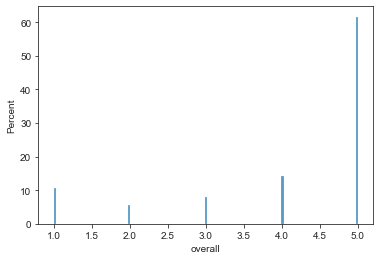

In [ ]:
sns.set_style("ticks")
sns.histplot(ratings_trainings['overall'], stat = 'percent')

<AxesSubplot:xlabel='overall', ylabel='Percent'>

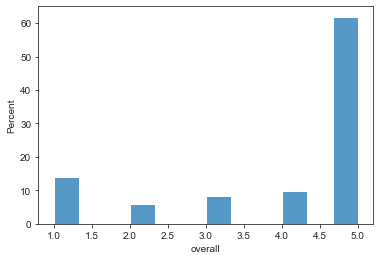

In [ ]:
sns.histplot(train_1m_before['overall'], stat = 'percent')

二、商品價格分佈情形：
1. 有購買記錄的商品價格分佈，看起來和全部產品的價格分佈相同，暗示幾乎每件商品都被買過，計算發現只有6件商品沒有銷售紀錄。
2. 多數被購買的商品<30元，可以考慮讓推薦系統過濾掉價格超過30元的商品。
3. 有567種被購買的商品不在商品清單裡(佔購買商品1.74%)：


<AxesSubplot:xlabel='price', ylabel='Percent'>

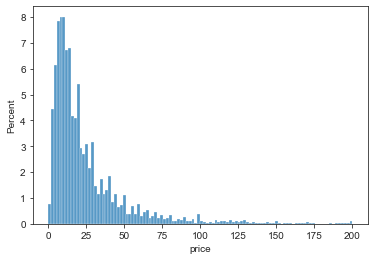

In [ ]:
sns.histplot(metadataB['price'], stat = 'percent', binrange = (0,200) )

In [ ]:
metadataB['price'].describe()

count    11019.000000
mean        27.942638
std         53.903673
min          0.010000
25%          8.990000
50%         15.990000
75%         29.990000
max       2149.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Percent'>

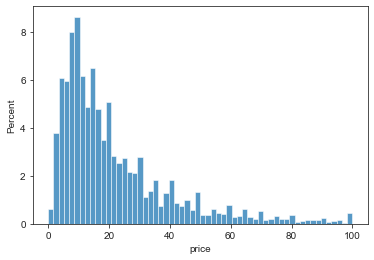

In [ ]:
buy_asin = pd.DataFrame(set(ratings_trainings['asin']), columns=['asin']).merge(metadataB, how= 'left', on = 'asin')
sns.histplot(buy_asin['price'], stat = 'percent', binrange = (0,100) )
    

In [ ]:
buy_asin['price'].describe()

count    11015.000000
mean        27.942666
std         53.911389
min          0.010000
25%          8.990000
50%         15.990000
75%         29.990000
max       2149.000000
Name: price, dtype: float64

In [ ]:
# 不在商品清單的被購商品們
len(set(ratings_trainings['asin'])) - len(set(metadataB['asin']))

567

In [ ]:
# 只有6件商品沒有銷售紀錄
len(set(metadataB['asin'])) - len(set(ratings_trainings['asin']) & set(metadataB['asin']))

6

三、探索重疊性：
1. 9成使用者只給過一次評價。
2. 4成以上的商品只得到1次評價。  

    適合設定min=2或3

Text(0.5, 1.0, 'all data')

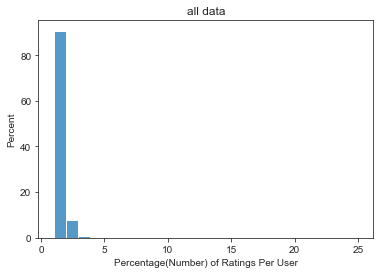

In [ ]:
ax=sns.histplot(ratings_trainings['reviewerID'].value_counts(), bins = 25, stat = 'percent')
ax.set(xlabel='Percentage(Number) of Ratings Per User')
plt.title('all data')

In [ ]:
# Number of Ratings Per User
ratings_trainings['reviewerID'].value_counts().value_counts()

1     293485
2      25071
3       3015
4       1177
5        503
6        115
7         48
8         28
9         20
11         8
10         7
12         3
20         3
13         2
22         1
14         1
16         1
25         1
Name: reviewerID, dtype: int64

Text(0.5, 1.0, 'all data')

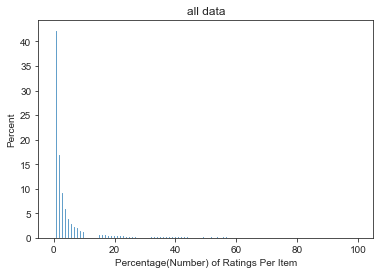

In [ ]:
ax=sns.histplot(ratings_trainings['asin'].value_counts(), stat = 'percent', binrange = (0,100))
ax.set(xlabel='Percentage(Number) of Ratings Per Item')
plt.title('all data')

In [ ]:
# Number of Ratings Per Item
ratings_trainings['asin'].value_counts().value_counts().head(10)

1     13519
2      5411
3      2953
4      1850
5      1248
6       896
7       711
8       616
9       438
10      405
Name: asin, dtype: int64

過濾評價次數過低的資料，降低運算負擔，並測試推薦效果：

In [ ]:
min_item_ratings = 2
filter_items = ratings_trainings['asin'].value_counts() >= min_item_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 3 # 如果設定2手刻程式碼會跑不動
filter_users = ratings_trainings['reviewerID'].value_counts() >= min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

small_ratings_trainings = ratings_trainings[(ratings_trainings['asin'].isin(filter_items)) & (ratings_trainings['reviewerID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings_trainings.shape))
print('The new data frame shape:\t{}'.format(small_ratings_trainings.shape))


The original data frame shape:	(361682, 5)
The new data frame shape:	(17551, 5)


四、KNN校正考量：
1. 不論是有無過濾評論數的資料，一半以上的使用者給分偏高，集中在5分。因為個體差異不大，預期校正Mean不會有太大差別。
2. 40-50%的商品平均分數集中在5分，再度預期校正Mean不會有太大差別。
3. 高達6、7成的使用者評分標準差為0（可能是多數人只評一次的關係），標準化校正可能沒有差異。
4. 25-35%的商品評價標準差集中在0，分佈的集中情形沒有以上三種那麼明顯，不確定標準化校正的影響。


使用者評分的平均數分布：

Text(0.5, 1.0, 'all data')

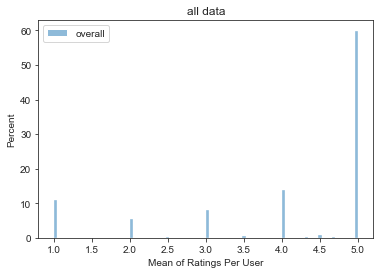

In [ ]:
ax=sns.histplot(ratings_trainings.groupby('reviewerID').agg({'overall':'mean'}), stat = 'percent' )
ax.set(xlabel='Mean of Ratings Per User')
plt.title('all data')

In [ ]:
ratings_trainings.groupby('reviewerID').agg({'overall':'mean'}).value_counts()

overall 
5.000000    193823
4.000000     44865
1.000000     35243
3.000000     26011
2.000000     17683
             ...  
1.250000         1
4.111111         1
4.222222         1
4.363636         1
3.777778         1
Length: 81, dtype: int64

Text(0.5, 1.0, 'small data')

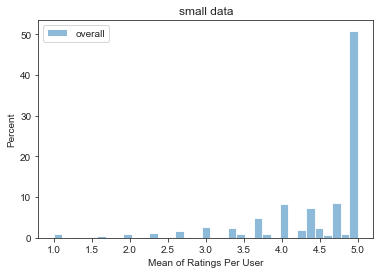

In [ ]:
ax=sns.histplot(small_ratings_trainings.groupby('reviewerID').agg({'overall':'mean'}), stat = 'percent' )
ax.set(xlabel='Mean of Ratings Per User')
plt.title('small data')

商品評分的平均數分布：

Text(0.5, 1.0, 'all data')

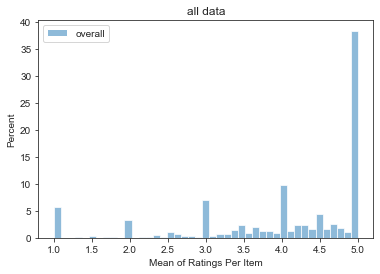

In [ ]:
ax=sns.histplot(ratings_trainings.groupby('asin').agg({'overall':'mean'}), stat = 'percent' )
ax.set(xlabel='Mean of Ratings Per Item')
plt.title('all data')

In [ ]:
ratings_trainings.groupby('asin').agg({'overall':'mean'}).value_counts()

overall 
5.000000    12413
4.000000     3052
3.000000     2254
1.000000     1866
4.500000     1151
            ...  
3.847826        1
3.844156        1
3.843750        1
3.839623        1
4.027027        1
Length: 1816, dtype: int64

Text(0.5, 1.0, 'small data')

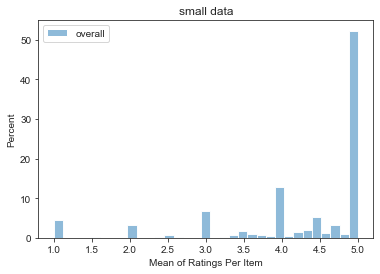

In [ ]:
ax=sns.histplot(small_ratings_trainings.groupby('asin').agg({'overall':'mean'}), stat = 'percent' )
ax.set(xlabel='Mean of Ratings Per Item')
plt.title('small data')

使用者評分的標準差分佈：

Text(0.5, 1.0, 'all data')

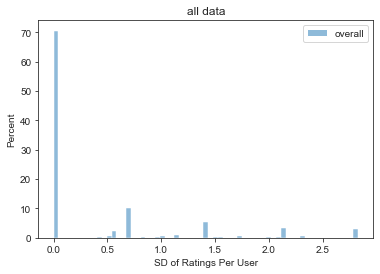

In [ ]:
ax=sns.histplot(ratings_trainings.groupby('reviewerID').agg({'overall':'std'}), stat = 'percent')
ax.set(xlabel='SD of Ratings Per User')
plt.title('all data')

In [ ]:
ratings_trainings.groupby('reviewerID').agg({'overall':'std'}).value_counts()

overall 
0.000000    21159
0.707107     3039
1.414214     1660
2.121320      968
2.828427      939
            ...  
0.975900        1
0.966092        1
0.951190        1
0.916125        1
1.050063        1
Length: 164, dtype: int64

Text(0.5, 1.0, 'small data')

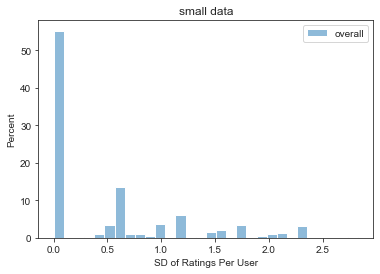

In [ ]:
ax=sns.histplot(small_ratings_trainings.groupby('reviewerID').agg({'overall':'std'}), stat = 'percent')
ax.set(xlabel='SD of Ratings Per User')
plt.title('small data')

商品評分的標準差分佈：

Text(0.5, 1.0, 'all data')

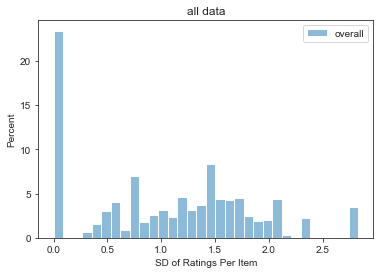

In [ ]:
ax=sns.histplot(ratings_trainings.groupby('asin').agg({'overall':'std'}), stat = 'percent')
ax.set(xlabel='SD of Ratings Per Item')
plt.title('all data')

In [ ]:
ratings_trainings.groupby('asin').agg({'overall':'std'}).value_counts()

overall 
0.000000    4460
0.707107    1061
1.414214     830
2.828427     660
2.121320     501
            ... 
1.207122       1
1.207122       1
1.207530       1
1.208034       1
1.335188       1
Length: 4159, dtype: int64

Text(0.5, 1.0, 'small data')

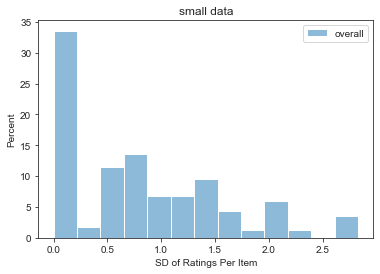

In [ ]:
ax=sns.histplot(small_ratings_trainings.groupby('asin').agg({'overall':'std'}), stat = 'percent')
ax.set(xlabel='SD of Ratings Per Item')
plt.title('small data')

### Cold Start Problem

冷啟動問題有很多處理方法，其中一種是透過尋找代表性用戶來預測新客戶的行為，雖然一般會有更多資料輔助（例如讓用戶選填幾個與偏好有關的簡單問題，或利用連結的個人社群網站資料等等），但我想就目前有的資料找找看新用戶有沒有什麼共通的行為，看能不能作為代表性資料用在協同過濾上。

以下粗略探索新用戶購買行為的共通點：  
（只是照自己亂想的在探索，後面推薦系統的嘗試也是）

In [ ]:
# 2018_8月：新戶1551/資料1566
new_cus_1m_before = set(train_1m_before['reviewerID']) - set(ratings[(ratings['DATE'] < '2018-08-01')]['reviewerID'])
data_new_cus_1m_before = pd.DataFrame(new_cus_1m_before, columns=['reviewerID']).merge(train_1m_before, how = 'left', on = 'reviewerID')

# 2018_7月：新戶2225/資料2255
new_cus_2m_before = set(train_2m_before['reviewerID']) - set(ratings[(ratings['DATE'] < '2018-07-01')]['reviewerID'])
data_new_cus_2m_before = pd.DataFrame(new_cus_2m_before, columns=['reviewerID']).merge(train_2m_before, how = 'left', on = 'reviewerID')

# 2018_5月：新戶1551/資料1566
train_5 = ratings[(ratings['DATE'] >= '2018-05-01') & (ratings['DATE'] <= '2018-05-31')]# 
new_cus_5 = set(train_5['reviewerID']) - set(ratings[(ratings['DATE'] < '2018-05-01')]['reviewerID'])
data_new_cus_5 = pd.DataFrame(new_cus_5, columns=['reviewerID']).merge(train_5, how = 'left', on = 'reviewerID')

# 2018_2月：新戶1551/資料1566
train_2 = ratings[(ratings['DATE'] >= '2018-02-01') & (ratings['DATE'] <= '2018-02-28')]# 
new_cus_2 = set(train_2['reviewerID']) - set(ratings[(ratings['DATE'] < '2018-02-01')]['reviewerID'])
data_new_cus_2 = pd.DataFrame(new_cus_2, columns=['reviewerID']).merge(train_2, how = 'left', on = 'reviewerID')

# 2017_9月：新戶2774/資料2805
train_9 = ratings[(ratings['DATE'] >= '2017-09-01') & (ratings['DATE'] <= '2017-09-30')]# 1641
new_cus_9 = set(train_9['reviewerID']) - set(ratings[(ratings['DATE'] < '2017-09-01')]['reviewerID'])
data_new_cus_9 = pd.DataFrame(new_cus_9, columns=['reviewerID']).merge(train_9, how = 'left', on = 'reviewerID')



新用戶購買的商品重疊率如何？（有哪些商品是新用戶都會買的嗎）  
以月份切分發現，任兩個月之間，新用戶購買的商品有20%左右是相同的。

In [ ]:
# 2018_8月和7月新客戶購買商品重疊比率＝20%
len(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin']))/len(set(data_new_cus_1m_before['asin']) 
                                                                                   | set(train_2m_before['asin']))


0.20048602673147023

In [ ]:
# 2018_7月和5月新客戶購買商品重疊比率＝19.2%
len(set(data_new_cus_2m_before['asin']) & set(data_new_cus_5['asin']))/len(set(data_new_cus_2m_before['asin'])
                                                                         | set(data_new_cus_5['asin']))

0.19247404844290658

In [ ]:
# 2018_5月和2017_9月新客戶購買商品重疊比率＝20.3%
len(set(data_new_cus_5['asin']) & set(data_new_cus_9['asin']))/len(set(data_new_cus_5['asin'])
                                                                 | set(data_new_cus_9['asin']))

0.2039911308203991

這些重疊的商品是相同的嗎？  
發現雖然重疊比率類似，但並不是相同商品，重疊的商品項目會隨著時間變化。

In [ ]:
# 2018_8_7月新客戶購買商品重疊幾項？ 330
len(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin']))

330

In [ ]:
# 2018_8_7_5月新客戶購買商品重疊幾項？ 224
len(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin']) & set(data_new_cus_5['asin']) )

224

In [ ]:
# 2018_8_7_5_2月新客戶購買商品重疊幾項？ 176
len(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin']) & set(data_new_cus_5['asin']) 
     & set(data_new_cus_2['asin']))

176

In [ ]:
# 2018_8_7_5_2月、2017_9月新客戶購買商品重疊幾項？ 135
len(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin']) & set(data_new_cus_5['asin']) 
     & set(data_new_cus_2['asin']) & set(data_new_cus_9['asin']))

135

準備資料以便探索新用戶對重疊商品的評分行為：

In [ ]:

overlap_8_7 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin']), 
                         columns=['asin']).merge(data_new_cus_1m_before[['asin','overall']], how = 'left', on = 'asin')
overlap_7 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin']), 
                         columns=['asin']).merge(data_new_cus_2m_before[['asin','overall']], how = 'left', on = 'asin')


overlap_8_5 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_5['asin']), 
                         columns=['asin']).merge(data_new_cus_1m_before[['asin','overall']], how = 'left', on = 'asin')
overlap_5 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_5['asin']), 
                         columns=['asin']).merge(data_new_cus_5[['asin','overall']], how = 'left', on = 'asin')


overlap_8_2 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2['asin']), 
                         columns=['asin']).merge(data_new_cus_1m_before[['asin','overall']], how = 'left', on = 'asin')
overlap_2 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_2['asin']), 
                         columns=['asin']).merge(data_new_cus_2[['asin','overall']], how = 'left', on = 'asin')


overlap_8_9 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_9['asin']), 
                         columns=['asin']).merge(data_new_cus_1m_before[['asin','overall']], how = 'left', on = 'asin')
overlap_9 = pd.DataFrame(set(data_new_cus_1m_before['asin']) & set(data_new_cus_9['asin']), 
                         columns=['asin']).merge(data_new_cus_9[['asin','overall']], how = 'left', on = 'asin')



In [ ]:

overlap_8_9.asin = pd.Categorical(overlap_8_9.asin)
overlap_8_9['cat_code'] = overlap_8_9.asin.cat.codes

overlap_9.asin = pd.Categorical(overlap_9.asin)
overlap_9['cat_code'] = overlap_9.asin.cat.codes

overlap_8_7.asin = pd.Categorical(overlap_8_7.asin)
overlap_8_7['cat_code'] = overlap_8_7.asin.cat.codes

overlap_7.asin = pd.Categorical(overlap_7.asin)
overlap_7['cat_code'] = overlap_7.asin.cat.codes

overlap_8_5.asin = pd.Categorical(overlap_8_5.asin)
overlap_8_5['cat_code'] = overlap_8_5.asin.cat.codes

overlap_5.asin = pd.Categorical(overlap_5.asin)
overlap_5['cat_code'] = overlap_5.asin.cat.codes

overlap_8_2.asin = pd.Categorical(overlap_8_2.asin)
overlap_8_2['cat_code'] = overlap_8_2.asin.cat.codes

overlap_2.asin = pd.Categorical(overlap_2.asin)
overlap_2['cat_code'] = overlap_2.asin.cat.codes


以2018年8月的新戶購買資料和2018年7、5、2月、2017年9月的新戶購買資料相比：  

1. 新戶對共同商品有類似的評價，相關值都在.2上下，但顯著。  
2. 任兩個月之間重疊的購買商品數都在330項上下。  

後續嘗試把這樣的關聯用在推薦系統上。

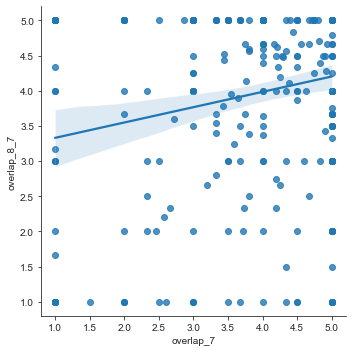

In [ ]:
# 2018_8_7月新客戶對共同購買商品的評價分布圖 並相關分析，看新客戶對共同商品的評價是否雷同 
data_overlap_8_7 = pd.DataFrame({'overlap_7':overlap_7.groupby('cat_code').agg({'overall':'mean'})['overall'],
                              'overlap_8_7':overlap_8_7.groupby('cat_code').agg({'overall':'mean'})['overall']})
sns.lmplot(data = data_overlap_8_7, x = 'overlap_7', y = 'overlap_8_7')

In [ ]:
# 相關值不高 但顯著
from scipy.stats import pearsonr
pearsonr(x = overlap_7.groupby('cat_code').agg({'overall':'mean'})['overall'],
         y = overlap_8_7.groupby('cat_code').agg({'overall':'mean'})['overall'])

(0.217484563523118, 6.788008337786019e-05)

In [ ]:
# 重疊商品數
len(overlap_7.groupby('cat_code').agg({'overall':'mean'})['overall'])

330

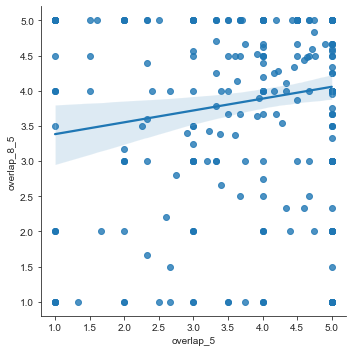

In [ ]:
# 2018_8_5月新客戶對共同購買商品的評價分布圖 並相關分析，看新客戶對共同商品的評價是否雷同 
data_overlap_8_5 = pd.DataFrame({'overlap_5':overlap_5.groupby('cat_code').agg({'overall':'mean'})['overall'],
                              'overlap_8_5':overlap_8_5.groupby('cat_code').agg({'overall':'mean'})['overall']})
sns.lmplot(data = data_overlap_8_5, x = 'overlap_5', y = 'overlap_8_5')

In [ ]:
# 相關值不高 但顯著
pearsonr(x = overlap_5.groupby('cat_code').agg({'overall':'mean'})['overall'],
         y = overlap_8_5.groupby('cat_code').agg({'overall':'mean'})['overall'])

(0.16530609906551658, 0.0022286928993504357)

In [ ]:
# 重疊商品數
len(overlap_5.groupby('cat_code').agg({'overall':'mean'})['overall'])

340

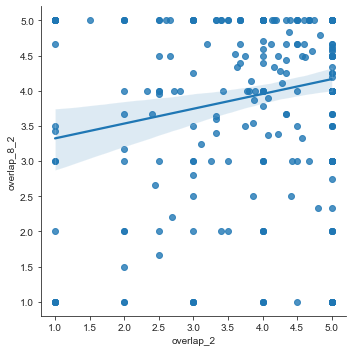

In [ ]:
# 2018_8_2月新客戶對共同購買商品的評價分布圖 並相關分析，看新客戶對共同商品的評價是否雷同 
data_overlap_8_2 = pd.DataFrame({'overlap_2':overlap_2.groupby('cat_code').agg({'overall':'mean'})['overall'],
                              'overlap_8_2':overlap_8_2.groupby('cat_code').agg({'overall':'mean'})['overall']})
sns.lmplot(data = data_overlap_8_2, x = 'overlap_2', y = 'overlap_8_2')

In [ ]:
# 相關值不高 但顯著
pearsonr(x = overlap_2.groupby('cat_code').agg({'overall':'mean'})['overall'],
         y = overlap_8_2.groupby('cat_code').agg({'overall':'mean'})['overall'])

(0.20391031680652633, 0.00017934825709251226)

In [ ]:
# 重疊商品數
len(overlap_2.groupby('cat_code').agg({'overall':'mean'})['overall'])

333

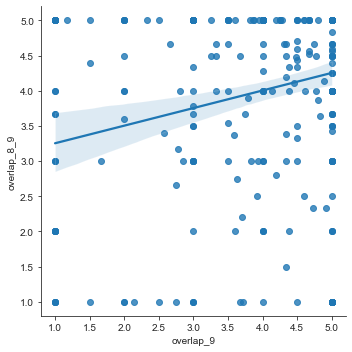

In [ ]:
# 2018_8月和2017_9月新客戶對共同購買商品的評價分布圖 並相關分析，看新客戶對共同商品的評價是否雷同 
data_overlap_8_9 = pd.DataFrame({'overlap_9':overlap_9.groupby('cat_code').agg({'overall':'mean'})['overall'],
                              'overlap_8_9':overlap_8_9.groupby('cat_code').agg({'overall':'mean'})['overall']})
sns.lmplot(data = data_overlap_8_9, x = 'overlap_9', y = 'overlap_8_9')

In [ ]:
# 相關值不高 但顯著
pearsonr(x = overlap_9.groupby('cat_code').agg({'overall':'mean'})['overall'],
         y = overlap_8_9.groupby('cat_code').agg({'overall':'mean'})['overall'])

(0.25106584132704945, 4.757455319899373e-06)

In [ ]:
# 重疊商品數
len(overlap_9.groupby('cat_code').agg({'overall':'mean'})['overall'])

324

### Feature Selection (for content-based)

* 說明：延續上週未完成的部分，將'discription'欄位與'title'和'brand'合併，成為商品文字描述特徵。
* 探索目的：預測文字特徵的效果，與上週資料比較。

In [ ]:
# 定義 permutation 函數，這邊採用 Mantel test，用來檢定兩個矩陣的相關性
from scipy.stats import spearmanr
def _permute_func(data1, data2, random_state=None):
    
    random_state = check_random_state(random_state)

    data_row_id = range(data1.shape[0])
    permuted_ix = np.random.choice(data_row_id, size=len(data_row_id), replace=False)
    new_fmri_dist = data1.iloc[permuted_ix, permuted_ix].values
    new_fmri_dist = new_fmri_dist[np.triu_indices(new_fmri_dist.shape[0], k=1)]
    return spearmanr(new_fmri_dist, data2)[0]

In [ ]:
# 定義計算 p-value 的函數
def _calc_pvalue(all_p, stat, tail):

    denom = float(len(all_p)) + 1
    if tail == 1:
        numer = np.sum(all_p >= stat) + 1 if stat >= 0 else np.sum(all_p <= stat) + 1
    elif tail == 2:
        numer = np.sum(np.abs(all_p) >= np.abs(stat)) + 1
    else:
        raise ValueError("tail must be either 1 or 2")
    return numer / denom

In [ ]:
# 定義矩陣相關檢驗函數
from joblib import Parallel, delayed
from sklearn.utils import check_random_state
from scipy.spatial.distance import squareform
MAX_INT = np.iinfo(np.int32).max

def matrix_permutation(
    data1,
    data2,
    n_permute=5000,
    tail=2,
    n_jobs=3,
    return_perms=False,
    random_state=None,
):
    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_permute)
    sq_data1 = squareform(data1)
   
    stats = {"rho": spearmanr(data1, data2)[0]}

    all_p = Parallel(n_jobs=n_jobs)(
        delayed(_permute_func)(
            pd.DataFrame(sq_data1), data2, random_state=seeds[i]
        )
        for i in range(n_permute)
    )
    stats["p"] = _calc_pvalue(all_p, stats["rho"], tail)
    if return_perms:
        stats["perm_dist"] = all_p
    return stats

In [ ]:
# text X buy_count---sig.

train_1m_data_c = train_1m_data.dropna(subset=['text'])

# 取得 文字描述 的 tfidf 矩陣
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix_tm1 = tf.fit_transform(train_1m_data_c['text'])

# 計算商品間的 文字描述 相似程度
sim_matrix_tm1 = cosine_similarity(tfidf_matrix_tm1)

# 計算商品間的 購買數/評論數 相似程度
sim_matrix_cm1 = euclidean_distances(train_1m_data_c['count'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對相似值
sim_cm1=sim_matrix_cm1[np.triu_indices(sim_matrix_cm1.shape[0], 1)]
sim_tm1=sim_matrix_tm1[np.triu_indices(sim_matrix_tm1.shape[0], 1)]

# 計算 文字描述相似度 和 購買數相似度 之間的相關值：顯著（比上週只用title的相關高，p值更低）
matrix_permutation(sim_cm1,sim_tm1)

{'rho': 0.08687819115863861, 'p': 0.0001999600079984003}

In [ ]:
# rank X buy_count---sig.
train_1m_data_c = train_1m_data.dropna(subset=['rank'])

# 計算商品間的 銷售排行 相似程度
sim_matrix_rm1 = euclidean_distances(train_1m_data_c['rank'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 銷售排行 相似值
sim_rm1=sim_matrix_rm1[np.triu_indices(sim_matrix_rm1.shape[0], 1)]

# 計算 銷售排行相似度 和 購買數相似度 之間的相關值：顯著
matrix_permutation(sim_cm1,sim_rm1)

{'rho': -0.04549966978492659, 'p': 0.020595880823835233}

In [ ]:
#price X buy_count---sig.
train_1m_data_c = train_1m_data.dropna(subset=['price'])

# 計算商品間的 價錢 相似程度
sim_matrix_pm1 = euclidean_distances(train_1m_data_c['price'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 價錢 相似值
sim_pm1=sim_matrix_pm1[np.triu_indices(sim_matrix_pm1.shape[0], 1)]

# 計算 價錢相似度 和 購買數相似度 之間的相關值：顯著
matrix_permutation(sim_cm1,sim_pm1)

{'rho': -0.06208782321542544, 'p': 0.016996600679864027}

In [ ]:
# overall(rate) X buy_count---non-sig.
train_1m_data_c = train_1m_data.dropna(subset=['rate'])

# 計算商品間的 評價 相似程度
sim_matrix_om1 = euclidean_distances(train_1m_data_c['rate'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 評價 相似值
sim_om1=sim_matrix_om1[np.triu_indices(sim_matrix_om1.shape[0], 1)]

# 計算 評價相似度 和 購買數相似度 之間的相關值：不顯著
matrix_permutation(sim_cm1,sim_om1)

{'rho': 0.029417608649952864, 'p': 0.1349730053989202}

<AxesSubplot:xlabel='rate', ylabel='count'>

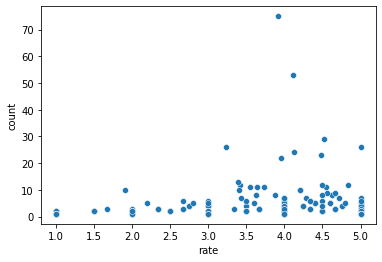

In [ ]:
# 評價 和 購買量 沒有明顯關聯
sns.scatterplot(x = train_1m_data['rate'], y= train_1m_data['count'])

<AxesSubplot:xlabel='rate', ylabel='rank'>

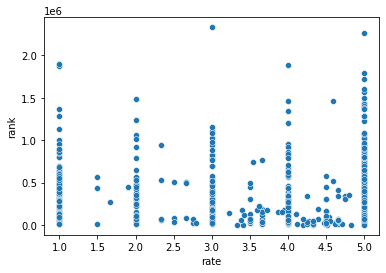

In [ ]:
# 評價 和 銷售排行 也沒有明顯關聯
sns.scatterplot(x = train_1m_data['rate'],y = train_1m_data['rank'])

In [ ]:
# brand X buy_count---non-sig.
train_1m_data_c2 = train_1m_data_c.replace('',np.nan)
train_1m_data_c2 = train_1m_data_c2.dropna(subset=['text', 'rank', 'price', 'brand'])

# 取得 品牌 的 One Hot Encoding (Dummies)
brand_dum = pd.get_dummies(train_1m_data_c2['brand'] , columns = ['brand'])

# 計算商品間的 品牌 相似程度
sim_matrix_bm1 = cosine_similarity(brand_dum)

# 計算商品間的 購買數/評論數 相似程度
sim_matrix_cm1 = euclidean_distances(train_1m_data_c2['count'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 品牌、購買數 相似值
sim_bm1=sim_matrix_bm1[np.triu_indices(sim_matrix_bm1.shape[0], 1)]
sim_cm1=sim_matrix_cm1[np.triu_indices(sim_matrix_cm1.shape[0], 1)]

# 計算 品牌相似度 和 購買數相似度 之間的相關值：不顯著
matrix_permutation(sim_cm1,sim_bm1)



{'rho': 0.005447916102956306, 'p': 0.14797040591881624}

In [ ]:
# rank + price X buy_count---sig. 
train_1m_data_c = train_1m_data.dropna(subset=['title', 'rank', 'price'])

# 合併 銷售排行 和 價錢，並取標準分數
rp = train_1m_data_c[['rank', 'price']]
rp_s = StandardScaler().fit_transform(rp)

# 計算商品間的相似程度
sim_matrix_rpm1 = cosine_similarity(rp_s)
sim_matrix_cm1 = euclidean_distances(train_1m_data_c['count'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 銷售排行＋價錢、購買數 相似值
sim_rpm1=sim_matrix_rpm1[np.triu_indices(sim_matrix_rpm1.shape[0], 1)]
sim_cm1=sim_matrix_cm1[np.triu_indices(sim_matrix_cm1.shape[0], 1)]

# 計算 銷售排行＋價錢相似度 和 購買數相似度 之間的相關值：顯著，而且變得比單一特徵更顯著
matrix_permutation(sim_cm1,sim_rpm1)

{'rho': 0.06272730697659003, 'p': 0.0001999600079984003}

In [ ]:
# text + rank + price X buy_count---sig. 
train_1m_data_c = train_1m_data.dropna(subset=['text', 'rank', 'price'])

# 取得 文字描述 的 tfidf 矩陣
tfidf_matrix_tm1 = tf.fit_transform(train_1m_data_c['text'])

# 合併 銷售排行 和 價錢，並取標準分數
rp = train_1m_data_c[['rank', 'price']]
rp_s = StandardScaler().fit_transform(rp)

# 合併 文字描述+銷售排行+價錢，取得特徵向量
vec_trpm1 = np.concatenate((np.matrix(tfidf_matrix_tm1.toarray()), rp_s), axis=1)

# 計算商品間的相似程度
sim_matrix_trpm1 = cosine_similarity(vec_trpm1)
sim_matrix_cm1 = euclidean_distances(train_1m_data_c['count'].array.reshape(-1, 1) )

# 取矩陣的上三角形＝商品間兩兩配對 文字描述+銷售排行＋價錢 相似值
sim_trpm1=sim_matrix_trpm1[np.triu_indices(sim_matrix_trpm1.shape[0], 1)]
sim_cm1=sim_matrix_cm1[np.triu_indices(sim_matrix_cm1.shape[0], 1)]

# 計算 文字描述+銷售排行＋價錢相似度 和 購買數相似度 之間的相關值：顯著，相關值反而較 text 單一特徵差，也比 rank + price 差
matrix_permutation(sim_cm1,sim_trpm1)

{'rho': 0.05550237705404458, 'p': 0.0003999200159968006}

小結：
* 評價：評價相似度和購買數相似度無關，而且評價和銷售、購買數都沒有多大關係，決定不處理這個特徵，也不刪掉評價低的商品。
* 品牌：將資料清得更乾淨後，品牌相似度仍然和購買數相似度無關，所以不以One Hot Encoding處理這個特徵。
* 文字描述、銷售排行、價錢：這三個特徵的相似度都和購買數相似度有顯著相關，因此三個特徵都會納入評估商品相似度。


* 測試組合：
 1. 文字描述+銷售排行+價錢（相關較顯著）
 2. 只用 文字描述 （相關值較高）
 

## 產生推薦

### User-based collaborative filtering

In [ ]:
new_cus = set(ratings_testings['reviewerID']) - set(ratings_trainings['reviewerID'])

# 找出近兩個月間新戶共通的購買商品
overlap = set(data_new_cus_1m_before['asin']) & set(data_new_cus_2m_before['asin'])

# 將測試樣本的新戶ID隨機配對至2018年8月和7月購買了共通商品的新戶ID，產生新訓練集
# 基於新戶之間有共通性的發現而假設可以這樣替換嘗試，假設相近月份的新戶資料之間彼此具有一定的代表性
overlap_item_8 = data_new_cus_1m_before.loc[data_new_cus_1m_before['asin'].isin(overlap)].drop(columns = ['reviewerID'])
overlap_item_8['reviewerID'] = np.random.choice(list(new_cus), size = len(overlap_item_8))
overlap_train_1m_before = pd.concat([overlap_item_8,train_1m_before.loc[~train_1m_before['asin'].isin(overlap)]])
    
overlap_item_7 = data_new_cus_2m_before.loc[data_new_cus_2m_before['asin'].isin(overlap)].drop(columns = ['reviewerID'])
overlap_item_7['reviewerID'] = np.random.choice(list(new_cus), size = len(overlap_item_7))
overlap_train_2m_before = pd.concat([overlap_item_7,train_2m_before.loc[~train_2m_before['asin'].isin(overlap)]])
    
overlap_ratings_trainings = pd.concat([overlap_train_1m_before, overlap_train_2m_before, ratings[(ratings['DATE'] < '2018-07-01')]])

    

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender_U(training_data, users=[], k=10):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating

    # prepare data of computing user similarity 
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else:
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order

    recommendation = {}
    for user in users:
        if user in user_similarity:
            sim_users = user_similarity[user]
            recommended_items = []
            recommended_items_set = set()
            user_have_rated = set(user_to_items[user])
            stop_recommend = False
            for sim_user, _ in sim_users:
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1])
                for item, _ in items_from_sim_user:
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k:
                        stop_recommend = True
                        break
                if stop_recommend:
                    break
            recommendation[user] = recommended_items
        else:
            recommendation[user] = []
    return recommendation

ratings_by_user = recommender_U(ratings_trainings, users)
ratings_by_user

total users before filtering:  323489
total users  after filtering:  4793


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': [],
 'A19HVHRZDYFEOP': [],
 'A19JM38B861BO

In [ ]:
ratings_by_user_small = recommender_U(small_ratings_trainings, users)
ratings_by_user_small

total users before filtering:  4926
total users  after filtering:  4532


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': [],
 'A19HVHRZDYFEOP': [],
 'A19JM38B861BO

In [ ]:
ratings_by_user_overlap = recommender_U(overlap_ratings_trainings, users)
ratings_by_user_overlap

total users before filtering:  321842
total users  after filtering:  5201


{'A100XQFWKQ30O2': ['B00JVU3K9I',
  'B01C64NN8I',
  'B01DKQAXC0',
  'B010B5ZE4U',
  'B012Z7IHHI',
  'B00NT0AR7E',
  'B01DLBWFVQ',
  'B013XKHA4M',
  'B00ZGWVZB0',
  'B01AVJCDYA'],
 'A103T1QOGFCSEH': ['B016CTZ9LC',
  'B01EB5RR1Y',
  'B00Q794RMA',
  'B01FTP9LNC',
  'B00ZR3UP50',
  'B00W259T7G',
  'B012Z7IHHI',
  'B01C64NN8I',
  'B00NT0AR7E',
  'B0175PT3KK'],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': ['B016CTZ9LC',
  'B01EB5RR1Y',
  'B00Q794RMA',
  'B01FTP9LNC',
  'B00ZR3UP50',
  'B00JVU3K9I',
  'B01C64NN8I',
  'B00W259T7G',
  'B010B5ZE4U',
  'B019RF59O0'],
 'A1119JJ37ZLB8R': ['B00JVU3K9I',
  'B01C64NN8I',
  'B01DKQAXC0',
  'B010B5ZE4U',
  'B012Z7IHHI',
  'B00NT0AR7E',
  'B01DLBWFVQ',
  'B013XKHA4M',
  'B00ZGWVZB0',
  'B01AVJCDYA'],
 'A113UOOLBSZN52': ['B016CTZ9LC',
  'B01EB5RR1Y',
  'B00Q794RMA',
  'B01FTP9LNC',
  'B00ZR3UP50',
  'B00JVU3K9I',
  'B01C64NN8I',
  'B00W259T7G',
  'B010B5ZE4U',
  'B012Z7IHHI'],
 'A12M4U7WK4ALCR': ['B01GKK7HF4',
  'B01GO2E4EA',
  'B01BWZL9PQ',
  'B0134OX6FY',


### Item-based collaborative filtering 

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender_I(training_data, users=[], k=10):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

    print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation    

ratings_by_user_IB = recommender_I(ratings_trainings, users)
ratings_by_user_IB

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00BWIT33Y'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B000EE9XYG',
  'B007SA3AUW',
  'B000FVHRXC',
  'B001U4RGOS',
  'B01CRWLLX8',
  'B004E4GHRS',
  'B006IB5T4W',
  'B00B0SA1SC',
  'B00JYGWWIO',
  'B00L88S190'],
 'A174Y

In [ ]:
ratings_by_user_IB_small = recommender_I(small_ratings_trainings, users)
ratings_by_user_IB_small

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': [],
 'A19HVHRZDYFEOP': [],
 'A19JM38B861BO

In [ ]:
ratings_by_user_IB_overlap = recommender_I(overlap_ratings_trainings, users)
ratings_by_user_IB_overlap

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

{'A100XQFWKQ30O2': ['B00Q794RMA',
  'B019KVY1M2',
  'B01814GS02',
  'B00TV5GSM4',
  'B00Y3VA24G',
  'B01D1VBI78',
  'B019FWRG3C',
  'B0116VEKFM',
  'B013XKHA4M',
  'B01C79TFDY'],
 'A103T1QOGFCSEH': ['B01AVJCDYA',
  'B01C64NN8I',
  'B010B5ZE4U',
  'B0197UXBYU',
  'B00PYFR9PK',
  'B01CQ4X6C6',
  'B018SFOZYA',
  'B01E54U1U0',
  'B00ZGWVZB0',
  'B018J05XSQ'],
 'A106UKKSJ2KXPF': ['B00VF344X0',
  'B01B1WKG9U',
  'B01DKQAXC0',
  'B00O3097YI',
  'B01868X158',
  'B01AX2X5W4',
  'B018WCT01C',
  'B00X4DKZKU',
  'B0178H2LK4',
  'B00W259T7G'],
 'A10A7GV4D5A11V': ['B018WCT01C',
  'B01AIFGCSK',
  'B019F0G2CA',
  'B00NM5A4A6',
  'B00B7LKXLW',
  'B016CTZ9LC',
  'B01FTP9LNC',
  'B00Y40YTPY',
  'B01DLR9IDI',
  'B01C6MIGU0'],
 'A1119JJ37ZLB8R': ['B018WCT01C',
  'B00Z2AA0EO',
  'B01DFHDMS6',
  'B0195R1FT8',
  'B013XKHA4M',
  'B01FHVAVFK',
  'B01ENWOBUK',
  'B00P85Q3JY',
  'B01CTQF2TQ',
  'B01FWP41H0'],
 'A113UOOLBSZN52': ['B01AVJCDYA',
  'B012Z7IHHI',
  'B01BZV6VVY',
  'B00VB5N3X4',
  'B00X4DKZKU',
  'B00N

###  surprise_collaborative filtering

In [ ]:
import time
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore

def recommender_S(training_data, users=[], k=10, user_based=False, algo=KNNBasic):

    training_data = (
        training_data
        .sort_values("DATE", ascending=False)
        .groupby(['reviewerID', 'asin']).head(1)
    )

    reader = Reader(rating_scale=(0, 5))
    training_data = training_data[['reviewerID', 'asin', 'overall']]
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            recommend_items_iid = algo_impl.get_neighbors(iid, k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)
                if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            if len(recommend_item_list) >= k:
                recommend_item_list = recommend_item_list[:k]
                break
        recommendation[user] = recommend_item_list

    return recommendation

ratings_by_user_S = recommender_S(ratings_trainings, users)
ratings_by_user_S

Computing the cosine similarity matrix...
Done computing similarity matrix.


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00BWIT33Y',
  'B01DKQAXC0',
  'B01G53GFKO',
  'B014KEITCC',
  'B0168SXRR0',
  'B01AR19RZU',
  'B0175PT3KK',
  'B01CW24JXC',
  'B01CW8SDLU',
  'B01DUU06FK'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B017BJ8KFE',
  'B019R

In [ ]:
ratings_by_user_S_small = recommender_S(small_ratings_trainings, users)
ratings_by_user_S_small

Computing the cosine similarity matrix...
Done computing similarity matrix.


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': [],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': [],
 'A1786SKRAJXH86': [],
 'A17K2BUZ20WD2': [],
 'A17LYRFV645L0V': [],
 'A18LNGVXDZBTUR': [],
 'A19503XX7GU6J2': [],
 'A19HVHRZDYFEOP': [],
 'A19JM38B861BO

In [ ]:
ratings_by_user_S_overlap = recommender_S(overlap_ratings_trainings, users)
ratings_by_user_S_overlap

Computing the cosine similarity matrix...
Done computing similarity matrix.


{'A100XQFWKQ30O2': ['B017M402PO',
  'B01CD7JK9E',
  'B01DKQAXC0',
  'B017BJ8KFE',
  'B013XKHA4M',
  'B012Z7IHHI',
  'B01CW24JXC',
  'B0195R1FT8',
  'B015ZTNN7W',
  'B01AAVIO38'],
 'A103T1QOGFCSEH': ['B01AR19RZU',
  'B01DJI7796',
  'B016YROO36',
  'B01DR9B6JO',
  'B01D0I2PW4',
  'B01HI1YKIG',
  'B01EHXK0W8',
  'B019KVXL96',
  'B019JE4PTE',
  'B01H4BQUZG'],
 'A106UKKSJ2KXPF': ['B01DKQAXC0',
  'B01AX2X5W4',
  'B0178H2LK4',
  'B013XKHA4M',
  'B01B1WKG9U',
  'B018WCT01C',
  'B01868X158',
  'B01FNJ9MOW',
  'B00W259T7G',
  'B00VF344X0'],
 'A10A7GV4D5A11V': ['B018WCT01C',
  'B01AIFGCSK',
  'B019F0G2CA',
  'B01AR19RZU',
  'B016YROO36',
  'B01DR9B6JO',
  'B01D0I2PW4',
  'B01HI1YKIG',
  'B01EHXK0W8',
  'B019KVXL96'],
 'A1119JJ37ZLB8R': ['B017M402PO',
  'B017BJ8KFE',
  'B01CJNZKZK',
  'B01CRSWZAU',
  'B018SFOZYA',
  'B01ENS6XDC',
  'B01AMOTPI6',
  'B0195R1FT8',
  'B015ZTNN7W',
  'B013XKHA4M'],
 'A113UOOLBSZN52': ['B0168SXRR0',
  'B012Z7IHHI',
  'B01FX13TYO',
  'B01AVJCDYA',
  'B017JHO7BO',
  'B011

In [ ]:
ratings_by_user_S_M = recommender_S(ratings_trainings, users, algo = KNNWithMeans)
ratings_by_user_S_repre_M = recommender_S(repre_ratings_trainings, users, algo = KNNWithMeans)
ratings_by_user_S_item_M = recommender_S(item_ratings_trainings, users, algo = KNNWithMeans)
ratings_by_user_S_overlap_M = recommender_S(overlap_ratings_trainings, users, algo = KNNWithMeans)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
ratings_by_user_S_Z = recommender_S(ratings_trainings, users, algo = KNNWithZScore)
ratings_by_user_S_repre_Z = recommender_S(repre_ratings_trainings, users, algo = KNNWithZScore)
ratings_by_user_S_item_Z = recommender_S(item_ratings_trainings, users, algo = KNNWithZScore)
ratings_by_user_S_overlap_Z = recommender_S(overlap_ratings_trainings, users, algo = KNNWithZScore)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


### Content-based

In [ ]:
#製作欲比較之商品列表 asin（前一個月被購買過的商品＋舊客戶購買過的商品(51)＝866項）
reg_cus_ = ratings_testings.merge(ratings_trainings[['reviewerID','asin']], how='left', on='reviewerID')
reg_cus_buy = reg_cus_[['reviewerID','asin_y']].rename(columns={'asin_y':'asin'}).dropna().drop_duplicates('asin')
asin = pd.concat([reg_cus_buy['asin'], train_1m_before['asin']]).drop_duplicates().reset_index().drop(columns=['index'])

#加入處理後商品資訊'text','rank','price'，刪除資訊不齊的品項後，從866筆清理至632筆(刪除27%)。 
asin_info = asin.merge(metadataB[['asin','title','text','rank','price']], how='left', on='asin').replace('', np.nan).dropna().reset_index().drop(columns=['index'])
asin_info.head()

,asin,title,text,rank,price
0,B01H6W0UH2,technic colour fix cream 8 colour corrector pa...,technic technic colour fix cream 8 colour corr...,233719.0,5.99
1,B0195R1FT8,booty magic | butt enhancement cream 2 month ...,booty magic booty magic | butt enhancement cre...,20807.0,39.95
2,B002OITLG0,fairy tales tangle tamer static free nbspdeta...,fairy tales fairy tales tangle tamer static f...,872.0,8.40
3,B000WYJTZG,helen of troy 1579 tangle free hot air brush w...,helen of troy helen of troy 1579 tangle free h...,4421.0,28.70
4,B00NFUXX6K,got 2b powderful volumizing style powder 0.35 ...,got2b got 2b powderful volumizing style powder...,6124.0,13.88


In [ ]:
# 計算每件商品的購買數/評論數
train_1m_buy = train_1m_before.groupby('asin').agg({'asin':'count'}).rename(columns={'asin':'count'}).reset_index()

# 計算每件商品的平均評價
rate_1m = train_1m_before.groupby('asin').agg({'overall':'mean'}).rename(columns={'overall':'rate'}).reset_index()

# 加入購買數和評價資料
train_1m_data = train_1m_buy.merge(rate_1m, how = 'left', on = 'asin').merge(metadataB, how = 'left', on = 'asin')


In [ ]:
# 1.舊戶推薦方法一

# 特徵：商品描述、價錢、銷售排行
# 客戶：舊


# 計算商品用 品名 所表示的 tfidf 矩陣
tf = TfidfVectorizer(analyzer='word')
asin_info.reset_index()
tfidf_matrix_tm1 = tf.fit_transform(asin_info['text'])

# 取得商品用 title + rank + price 所表示的特徵向量 (事先將 rank 和 price 轉成標準分數，降低測量指標不同的影響)
rp = asin_info[['rank', 'price']]
rp_s = StandardScaler().fit_transform(rp)
vec_trpm1 = np.concatenate((np.matrix(tfidf_matrix_tm1.toarray()), rp_s), axis=1)
mapping = pd.Series(asin_info.index,index = asin_info['asin'])

# 計算商品間的相似程度
sim_matrix = cosine_similarity(vec_trpm1)

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(sim_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (asin_info['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res


# 只針對舊客戶，依據過去購買商品推薦相似的產品，不考慮新客戶，以評估只用內容推薦的成效。
def recommender1(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: recommend_items(asin_info[asin_info['asin'].isin(ratings_trainings
                       [ratings_trainings['reviewerID'] == user]['asin'].tolist())]['asin'].tolist(), k) 
                       for user in users}
    return recommendations

ratings_by_user1 = recommender1(ratings_trainings, reg_cus)
ratings_by_user1

{'A2M4YSOJZELJ6N': ['B01H6W0UH2',
  'B0189H1QKS',
  'B01E0HARGU',
  'B01HD23OJG',
  'B013KTNIME',
  'B01EAIDMUM',
  'B017BJ7RG2',
  'B007Z5RTRK',
  'B017X2K6R4',
  'B0159ZECGI'],
 'A2GFPTQ4VWDX96': [],
 'A2BU6N5956T9NH': ['B00W259T7G',
  'B019FWRG3C',
  'B01E0HARGU',
  'B00S81E1XK',
  'B01A6XK12W',
  'B0178H2LK4',
  'B013KTNIME',
  'B01FY4WF54',
  'B01H3IVSAC',
  'B00NE5Q9JO'],
 'AQYL4TDY2HU8Z': ['B003B6QR5M',
  'B00N6FCRYS',
  'B00IAYT33S',
  'B01GR2V8Z0',
  'B00IUOH3KS',
  'B01FBFR7WW',
  'B01AE667W4',
  'B016LLBCX0',
  'B00KXHEURE',
  'B019PTEMCI'],
 'ACE1ZIOI3U6PY': ['B007NIR2C6',
  'B00IAYT33S',
  'B01GR1XPU2',
  'B015SP1Y10',
  'B01FBFR7WW',
  'B01GHPIHJ2',
  'B00N6FCRYS',
  'B01GR2V8Z0',
  'B01AE667W4',
  'B00GLNYQAU'],
 'A29834GBB4DOP1': ['B01COREXYA',
  'B01DSDPEZ6',
  'B01E53FJVW',
  'B00O3092KW',
  'B00O3097YI',
  'B00M2J4HXI',
  'B01D5FXSJG',
  'B015YL6MYM',
  'B00NE5ZHB0',
  'B01DJI7796'],
 'A7Y4ETTLARUGI': ['B00IUOH3KS',
  'B00N6FCRYS',
  'B00IAYT33S',
  'B01FBFR7WW',
  '

In [ ]:
# 2.舊戶推薦方法二

# 特徵：價錢、銷售排行
# 客戶：舊

# 計算商品間的相似程度
sim_matrix = cosine_similarity(tfidf_matrix_tm1)

ratings_by_user2 = recommender1(ratings_trainings, reg_cus)
ratings_by_user2

{'A2M4YSOJZELJ6N': ['B01H6W0UH2',
  'B0189H1QKS',
  'B01BUP23IK',
  'B01GGMFMVW',
  'B01254XUXW',
  'B01FQ4CEOY',
  'B01BJCX44Q',
  'B01HD23OJG',
  'B017NRCD52',
  'B00P85Q3JY'],
 'A2GFPTQ4VWDX96': [],
 'A2BU6N5956T9NH': ['B00W259T7G',
  'B019FWRG3C',
  'B00S81E1XK',
  'B0195X3O5A',
  'B0124H25UO',
  'B01DSDPEZ6',
  'B00WIZ2HUQ',
  'B019798BAA',
  'B00KU8NYZU',
  'B00YI0XFUU'],
 'AQYL4TDY2HU8Z': ['B003B6QR5M',
  'B01FGAELPS',
  'B0145VTRB2',
  'B01FNJ9MOW',
  'B00Z5VI9MK',
  'B01A6XK12W',
  'B0168SXRR0',
  'B01CWZHJ9A',
  'B019262AFU',
  'B001860E92'],
 'ACE1ZIOI3U6PY': ['B007NIR2C6',
  'B01E81N2CY',
  'B01HI1YKIG',
  'B014IVX9D6',
  'B017IJF730',
  'B01E12HBZ4',
  'B01BUP23IK',
  'B01C02Y01K',
  'B01H4BQUZG',
  'B01HBZNEHW'],
 'A29834GBB4DOP1': ['B01COREXYA',
  'B01E53FJVW',
  'B01BT28GXA',
  'B01DSDPEZ6',
  'B01FWNBB48',
  'B01GSRXKOG',
  'B01BE77YOC',
  'B015YL6MYM',
  'B00QF207JQ',
  'B00O3092KW'],
 'A7Y4ETTLARUGI': ['B00IUOH3KS',
  'B00PLKRHK0',
  'B017M7I8UW',
  'B01E5GSQOQ',
  '

## 結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

#evaluate(ratings_testings_by_user, ratings_by_user)

In [ ]:
def evaluate2(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0 
    non_emp = 0
    
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
    
    for user in users:
        if len(ratings_by_user[user]) > 0:
            non_emp += 1 

    score = total / non_emp
    return score

#evaluate(ratings_testings_by_user, ratings_by_user)

### User-based collaborative filtering

只看有被推薦商品的user:

In [ ]:
# 範本方法
evaluate2(ratings_testings_by_user, ratings_by_user)

0.0

In [ ]:
# 過濾評價不足2筆的商品和用戶
evaluate2(ratings_testings_by_user, ratings_by_user_small)

0.0

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate2(ratings_testings_by_user, ratings_by_user_overlap)

0.07476635514018691

看所有user:

In [ ]:
# 範本方法
evaluate(ratings_testings_by_user, ratings_by_user)

0.0

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate(ratings_testings_by_user, ratings_by_user_overlap)

0.05423728813559322

### Item-based collaborative filtering

只看有被推薦商品的user:

In [ ]:
# 範本方法
evaluate2(ratings_testings_by_user, ratings_by_user_IB)

0.0

In [ ]:
# 過濾評價不足2筆的商品和用戶
evaluate2(ratings_testings_by_user, ratings_by_user_IB_small)

0.0

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate2(ratings_testings_by_user, ratings_by_user_IB_overlap)

0.033391915641476276

看所有user:

In [ ]:
# 範本方法
evaluate(ratings_testings_by_user, ratings_by_user_IB)

0.0

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate(ratings_testings_by_user, ratings_by_user_IB_overlap)

0.03220338983050847

### surprise_collaborative filtering

只看有被推薦商品的user:

In [ ]:
# 範本方法
evaluate2(ratings_testings_by_user, ratings_by_user_S)

0.05263157894736842

In [ ]:
# 過濾評價不足2筆的商品和用戶
evaluate2(ratings_testings_by_user, ratings_by_user_S_small)

0.0

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate2(ratings_testings_by_user, ratings_by_user_S_overlap)

0.059130434782608696

KNNWithMeans:

In [ ]:
# 範本方法
evaluate2(ratings_testings_by_user, ratings_by_user_S_M)

0.05263157894736842

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate2(ratings_testings_by_user, ratings_by_user_S_overlap_M)

0.059130434782608696

KNNWithZScore:

In [ ]:
# 範本方法
evaluate2(ratings_testings_by_user, ratings_by_user_S_Z)

0.05263157894736842

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate2(ratings_testings_by_user, ratings_by_user_S_overlap_Z)

0.059130434782608696

看所有user:

In [ ]:
# 範本方法
evaluate(ratings_testings_by_user, ratings_by_user_S)

0.003389830508474576

In [ ]:
# 新訓練集（假設相近月份的新戶資料之間彼此具有一定的代表性）
evaluate(ratings_testings_by_user, ratings_by_user_S_overlap)

0.0576271186440678

### Content-based

In [ ]:
# 1.舊戶推薦方法一

# 特徵：商品文字描述、價錢、銷售排行
# 客戶：舊

# 只針對舊客戶的內容推薦評估：Recall = 0.0 超慘，比上週只用title做內容推薦的效果還差。
# 有可能description裡面的資料質量很差所以效果反而更糟

dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
ratings_testings_by_reg_cus = dict_filter(ratings_testings_by_user, reg_cus)
ratings_testings_reg_cus = pd.DataFrame(reg_cus).rename(columns={0:'reviewerID'}).merge(ratings_testings, how ='left', on='reviewerID')

def evaluate1(ratings_testings_by_reg_cus={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_reg_cus:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_reg_cus[d]))

    score = total / len(ratings_testings_reg_cus)
    return score

evaluate1(ratings_testings_by_reg_cus, ratings_by_user1)


0.0

In [ ]:
# 2.舊戶推薦方法二

# 特徵：商品文字描述
# 客戶：舊

# 只用 商品文字描述 針對舊客戶的內容推薦評估：Recall = 0.0，很糟糕。
# 推測原因同上

evaluate1(ratings_testings_by_reg_cus, ratings_by_user2)


0.0